this tutorial is taken from: https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb

In [15]:
import stim

# Creating a surface code circuit and detecting errors

Let's generate the circuit without errors:

In [161]:
circuit = stim.Circuit.generated('surface_code:rotated_memory_z',
                                distance=3,
                                rounds=2)
print(repr(circuit))

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1

Plot the qubits and their role in the circuit

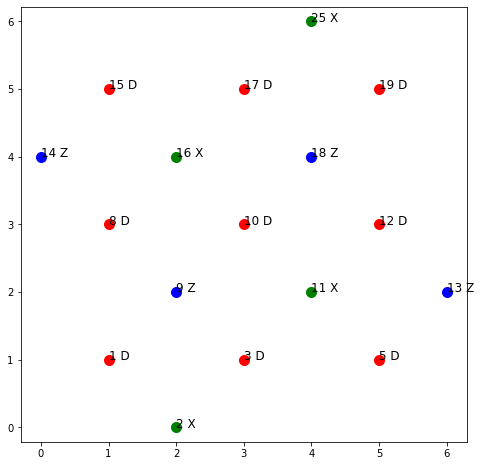

In [152]:
import matplotlib.pyplot as plt

coords = []
qnums = []
for st in repr(circuit).splitlines():
    st = st.strip()
    if st[0] == "Q":
        coord = st[st.find('(')+1:st.find(')')]
        coord = [int(s) for s in coord.split(',')]
        qnums.append(int(st.split(' ')[-1]))
#        print(coord)
        coords.append(coord)
coords = np.array(coords)
qnums = np.array(qnums)

plt.figure(figsize=(8, 8))
for qnum, coord in zip(qnums, coords):
    if coord[0] % 2 == 1:
        color = 'r'
        txt = 'D'
    elif sum(coord) % 4 == 2:
        color = 'g'
        txt = 'X'
    elif sum(coord) % 4 == 0:
        color = 'b'
        txt = 'Z'

    plt.plot(coord[0], coord[1], 'o'+color, markersize=10);
    plt.text(coord[0], coord[1], ' '.join((str(qnum), txt)), size='large');
plt.axis('equal');

We read off manually for now the z matching matrix. Here we create a 4 x 7 matrix since we data qubits 1, 3 and 17, 19. We do this because the ancillas can't distinguish between errors on them, and a the logical Z operator is only sensitive to their parity anyway

[[0 1 1 0 0 0 0]
 [0 0 1 1 0 0 1]
 [1 0 0 1 1 0 0]
 [0 0 0 0 1 1 0]]


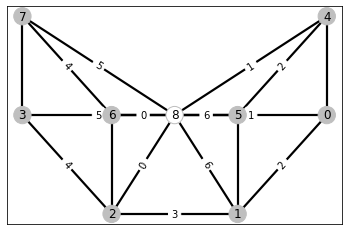

In [386]:
match_z_col_index = [17, 15, 8, 10, 12, 5, 3]
match_z_row_index = [14, 9, 18, 13]

logical_z_qubits = [1, 3, 5]
match_z = np.array([
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [1, 1, 0, 0],
    [0, 1, 1, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [0, 1, 0, 0]
]).T
import pymatching

print(match_z.astype(int))
mm = pymatching.Matching(H=match_z.astype(int), repetitions=2)
mm.draw()

Manually inject an error on all qubits and check if they can be corrected

In [438]:
circuit_err = stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    
    X_ERROR(1) 8 10
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK

    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4] 
    DETECTOR(2, 2, 0) rec[-7] 
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5] 

    M 1 3 5 8 10 12 15 17 19
    DETECTOR(0, 4, 1) rec[-3] rec[-6] 
    DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] 
    DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] 
    DETECTOR(6, 2, 1) rec[-4] rec[-7]
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
''')

sampler = circuit_err.compile_detector_sampler()
meas_res = sampler.sample(shots=1, append_observables=True)
detector_outcomes = meas_res[0, :-1].reshape(-1, 4)
logical_state = meas_res[0, -1]
print(f"uncorrected logical state = {logical_state}")
des = np.logical_xor(detector_outcomes[1:], detector_outcomes[:-1])  # detection events
print("detection events")
print(des.astype(int))

# decode the X errors

decoded = mm.decode(des.T)
print(decoded)
errors = [match_z_col_index[k] for k in decoded.nonzero()[0]]
print(f'error is in {errors}')
corrected_logical_state = np.logical_xor(logical_state, np.logical_xor(decoded[-1], decoded[-2]))
print(f'corrected logical state = {corrected_logical_state.astype(int)}')

uncorrected logical state = 0
detection events
[[1 0 1 0]
 [0 0 0 0]]
[1 1 0 0 0 0 0]
error is in [17, 15]
corrected logical state = 0
